In [20]:
import pandas as pd
import urllib
import urllib.request
import urllib.parse
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
%pylab inline
import jieba
import matplotlib.animation as animation
from IPython.display import HTML
from wordcloud import WordCloud, STOPWORDS
from googletrans import Translator
import subprocess
import re

Populating the interactive namespace from numpy and matplotlib


C:\Users\18518\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Chinese Data

In [2]:
dfch=pd.read_csv('chinesenews.csv')  

In [3]:
dfch['pubDate']=pd.to_datetime(dfch['pubDate'])

In [4]:
dfch = dfch[['pubDate','title','summary']]
dfch.columns.values[:]=['chDate','chtitle','chsummary']
dfch[['chtitle']]=dfch['chtitle'].str.cat(dfch['chsummary'],sep=" ")

In [5]:
dfch = dfch[['chDate','chtitle']]
dfch.columns.values[:]=['Date','chtext']
dfch['Date'] = dfch['Date'].dt.date

In [6]:
dfch.head()

,Date,chtext
0,2020-05-14,有必要进行全国全员检测吗？国务院联防联控机制专家：不需要！ 5 月 12 日，武汉市下发《关...
1,2020-05-14,法国总统府：疫苗应当同时提供给所有人 当地时间 14 日，法国药企赛诺菲（Sanofi）有关...
2,2020-05-14,法国总统府：疫苗应当同时提供给所有人 当地时间14日，法国药企赛诺菲（Sanofi）有关“新...
3,2020-05-14,有必要进行全国全员检测吗？国务院联防联控机制专家：不需要！ 5月12日，武汉市下发《关于开展...
4,2020-05-14,俄产新冠病毒疫苗将于6月份进行临床试验 并有望9月注册 当地时间14日，位于俄罗斯新西伯利亚...


In [7]:
min(dfch['Date'])

datetime.date(2019, 12, 31)

In [8]:
dfch.dtypes

Date      object
chtext    object
dtype: object

### English Data

In [9]:
dfeng=pd.read_csv('englishnews.csv') 

In [10]:
dfeng['publish_date']=dfeng['publish_date'].apply(pd.to_datetime, errors='coerce')
#filter date
dfeng=dfeng[dfeng['publish_date'] >= '2019-12-01']

dfeng['title'] = dfeng['title'].astype(str)
dfeng['description'] = dfeng['description'].astype(str)
dfeng['text'] = dfeng['text'].astype(str)


In [11]:
dfeng = dfeng[['publish_date','title','description','text']]
dfeng.columns.values[:]=['engDate','engtitle','engdescription','engtext']
dfeng[['engtitle']]=dfeng['engtitle'].str.cat(dfeng['engdescription'],sep=" ")
dfeng[['engtitle']]=dfeng['engtitle'].str.cat(dfeng['engtext'],sep=" ")
dfeng = dfeng[['engDate','engtitle']]
dfeng.columns.values[:]=['Date','engtext']
dfeng['Date'] = dfeng['Date'].dt.date

In [12]:
dfeng.head()

,Date,engtext
0,2020-05-03,'More vital now:' Gay-straight alliances go vi...
1,2020-05-02,Scientists aim to 'see' invisible transmission...
2,2020-05-02,Coronavirus: What's happening in Canada and ar...
3,2020-05-02,"B.C. announces 26 new coronavirus cases, new c..."
4,2020-05-02,"B.C. announces 26 new coronavirus cases, new c..."


### Combine data

In [13]:
dftotal = pd.merge(dfch, dfeng, on='Date',how='outer')

In [14]:
dftotal['month'] = pd.DatetimeIndex(dftotal['Date']).month

In [15]:
dftotal

,Date,chtext,engtext,month
0,2020-05-14,有必要进行全国全员检测吗？国务院联防联控机制专家：不需要！ 5 月 12 日，武汉市下发《关...,NaN,5
1,2020-05-14,法国总统府：疫苗应当同时提供给所有人 当地时间 14 日，法国药企赛诺菲（Sanofi）有关...,NaN,5
2,2020-05-14,法国总统府：疫苗应当同时提供给所有人 当地时间14日，法国药企赛诺菲（Sanofi）有关“新...,NaN,5
3,2020-05-14,有必要进行全国全员检测吗？国务院联防联控机制专家：不需要！ 5月12日，武汉市下发《关于开展...,NaN,5
4,2020-05-14,俄产新冠病毒疫苗将于6月份进行临床试验 并有望9月注册 当地时间14日，位于俄罗斯新西伯利亚...,NaN,5
...,...,...,...,...
418161,2020-03-25,NaN,Here's what to expect from Ontario's not-quite...,3
418162,2020-03-25,NaN,"Thunder Bay airport announces new, enhanced CO...",3
418163,2019-12-22,NaN,Sunday Scrum: Repatriating Canadians from Chin...,12
418164,2020-01-09,NaN,Previously unknown virus may be causing pneumo...,1


### English News Plot

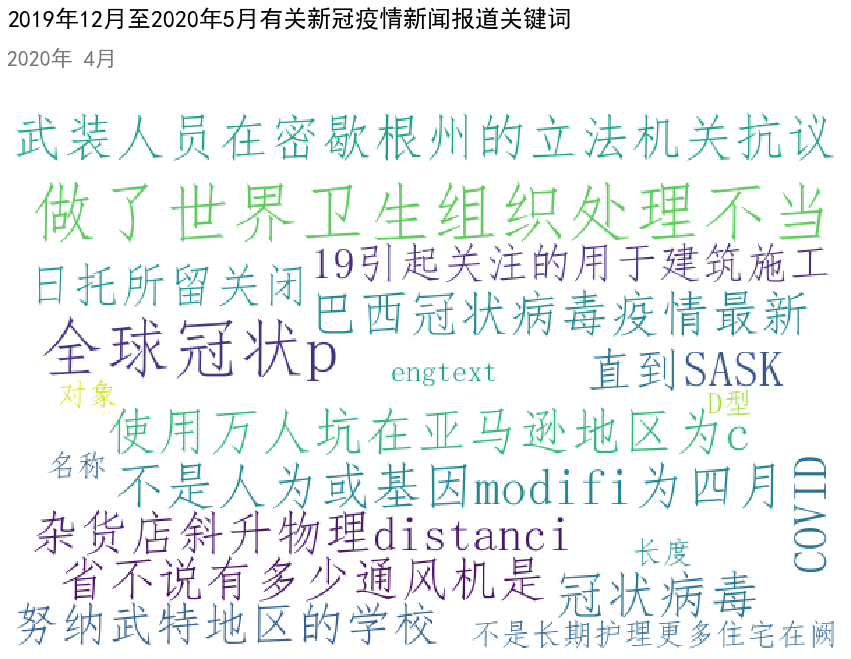

In [43]:
fig, ax = plt.subplots(figsize=(15, 30))
def draw_wordcloud(month):
    year = (2019 if month==12 else 2020)
    dff = (dftotal[dftotal['month']==month])
    text = ''.join(str(dff['engtext']))
    #remove numbers
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
    translator = Translator()
    mytext = translator.translate(text, dest='zh-cn').text
    
    ax.clear()
    wc = WordCloud(font_path='chinese.simfang.ttf', width=600, height=400, background_color="white", max_words=200)
    wc.generate(mytext)
    #添加月份
    ax.text(0, 1.05, str(year)+'年 '+str(month)+'月', transform=ax.transAxes, color='#777777', size=22, ha='left', weight=400)
    ax.text(0, 1.12, '2019年12月至2020年5月有关新冠疫情新闻报道关键词',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.margins(0, 0.01)
    ax.imshow(wc)
    plt.axis("off") # 取消坐标系
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.axis('off')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])

    plt.show()      # 在IDE中显示图片
draw_wordcloud(4)

### Chinese News

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\18518\AppData\Local\Temp\jieba.cache
Loading model cost 0.759 seconds.
Prefix dict has been built successfully.


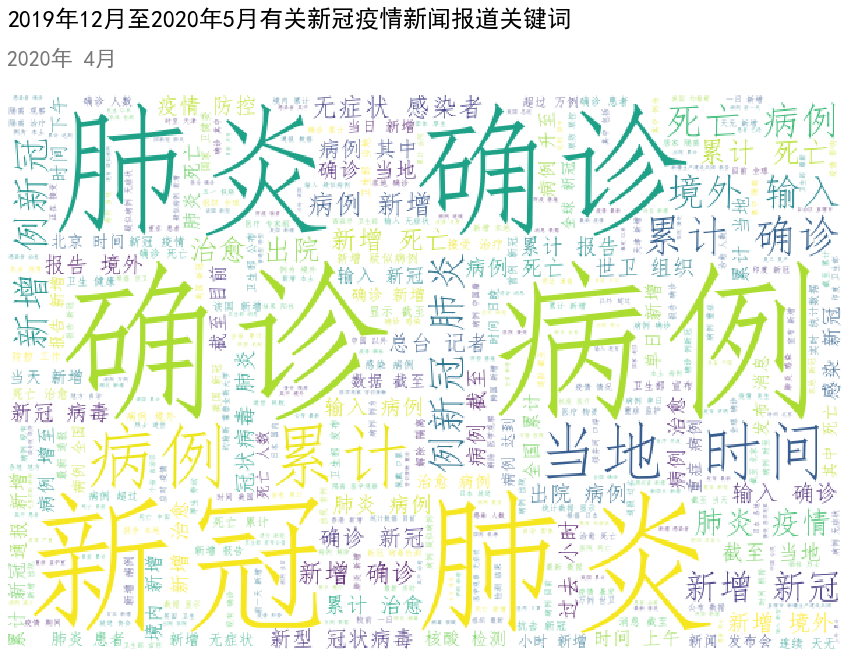

In [49]:
fig, ax = plt.subplots(figsize=(15, 30))
def draw_wordcloud(month):
    year = (2019 if month==12 else 2020)
    dff = (dftotal[dftotal['month']==month])
    text = ''.join(dff['chtext'])
    mytext = " ".join(jieba.cut(text))
    ax.clear()
    wc = WordCloud(font_path='chinese.simfang.ttf', width=600, height=400, background_color="white", max_words=4000)
    wc.generate(mytext)
    #添加月份
    ax.text(0, 1.05, str(year)+'年 '+str(month)+'月', transform=ax.transAxes, color='#777777', size=22, ha='left', weight=400)
    ax.text(0, 1.12, '2019年12月至2020年5月有关新冠疫情新闻报道关键词',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.margins(0, 0.01)
    ax.imshow(wc)
    plt.axis("off") # 取消坐标系
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.axis('off')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])

    plt.show()      # 在IDE中显示图片
draw_wordcloud(4)